In [1]:
import numpy as np
import scipy as sp
from scipy import io,integrate,sparse
import matplotlib.pyplot as plt

import os,sys
sys.path.insert(0, '..')
from partial_trace import *

from IPython.display import clear_output
np.set_printoptions(linewidth=300)
%load_ext autoreload
%autoreload 2


In [2]:
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font',size=10)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)

$\renewcommand{\vec}{\mathbf}$

We will consider a matrix
$$
\vec{H} := \sum_{i,j=1}^{N} \left[  J^{\text{x}}_{i,j} \vec{\sigma}^{\text{x}}_i \vec{\sigma}^{\text{x}}_j 
    +J^{\text{y}}_{i,j} \vec{\sigma}^{\text{y}}_i \vec{\sigma}^{\text{y}}_j
    +J^{\text{z}}_{i,j} \vec{\sigma}^{\text{z}}_i \vec{\sigma}^{\text{z}}_j \right] 
    + \frac{h}{2} \sum_{i=1}^{N} \sigma_i^{\text{z}}
$$
in the case $\vec{J}^{\text{z}}_{i,j} = 0$ and 
$$
\vec{J}^{\text{x/y}}_{i,j} = \begin{cases} 1 & |i-j| = 1 \\ 0 & \text{otherwise} \end{cases}.
$$


In [3]:
s = 1/2
M = int(2*s+1)

N = 12
n = M**N

N_s = 2
N_b = N-N_s
d_a = M**N_s
d_b = M**N_b

In [4]:
J_t = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if np.abs(i-j)==1:
            J_t[i,j] = 1

In [5]:
%%time
J = 1
h = .3*J

H = get_hamiltonian((J/2)*J_t,(J/2)*J_t,0*J_t,h,s)

CPU times: user 118 ms, sys: 8.2 ms, total: 126 ms
Wall time: 126 ms


We want to compute
$$
\rho^*(\beta):=
\frac{\operatorname{tr}_{\text{b}}( \exp(-\beta \vec{H}) )}{\operatorname{tr}(\operatorname{tr}_{\text{b}}( \exp(-\beta \vec{H}) ))}.
$$

In [6]:
%%time
# generate list of temperatures to evaluate at
n_βs = 100
βs = 1/np.logspace(-2,3,n_βs)

# projection subspace dimension
ks = [0,1,10]

# number of random samples
ms = [1,4,10]

CPU times: user 0 ns, sys: 287 µs, total: 287 µs
Wall time: 281 µs


In [7]:
k_top = max(ks)
Λk,Qk = sp.sparse.linalg.eigsh(H,k=k_top,which='SA')
E0 = Λk[0]

In [8]:
# number of times to independently run the algorithm
n_trials = 10

In [9]:
%%time
np.random.seed(0)
out_all = []
for i in range(n_trials+1): #+1 for LOO experiment
    
    out = {}
    for ki,k in enumerate(ks):
        for mi,m in enumerate(ms):
            print(f'trial:{i}/{n_trials}, k:{ki}/{len(ks)}, m:{mi}/{len(ms)}')
            clear_output(wait=True)
            
            # setup low-rank matrix and eigenvectors as bottom k
            if k==0:
                Qkk = None
            else:
                Qkk = Qk[:,:k]
     
            # use guess of the slowest function to converge and build termination condition
            f_hard = lambda x: np.exp(-np.max(βs)*(x-E0))
            termination_cond = get_termination_cond(f_hard,1e-10,5,verbose=1)
    
            # hard maximum iterations if no convergence
            max_iter = 50
            
            # get quadrature nodes/weights
            out[k,m] = fast_partial_trace_quadrature(H,Qkk,m,d_a,d_b,\
                                                     max_iter=max_iter,\
                                                     n_evec=k,\
                                                     termination_cond=termination_cond\
                                                    )
        
    out_all.append(out)

CPU times: user 1min 40s, sys: 4.21 s, total: 1min 44s
Wall time: 28.1 s


In [10]:
np.save('data/variance.npy',out_all,allow_pickle=True)
out_all = np.load('data/variance.npy',allow_pickle=True)

# Eigenvalues

Now we will compute the eigenvalues of $\rho^*(\beta)$ for all $\beta$

In [11]:
ρ_EVs_all = []
for i in range(n_trials):
    out = out_all[i]
    
    ρ_EVs = {}
    for ki,k in enumerate(ks):
        for mi,m in enumerate(ms):

            if k==0 and m==0: 
                continue
                
            ρ_EVs[k,m] = get_ρ_EVs_all(*out[k,m],E0,βs)

    ρ_EVs_all.append(ρ_EVs)


ρ_EVs_true = np.zeros((n_βs,d_a))      
for l,β in enumerate(βs):

    f = lambda x: np.exp(-β*(x-E0))
    ρ_EVs_true[l] = get_solvable_density_EVs(2*h,2*J,β,N)

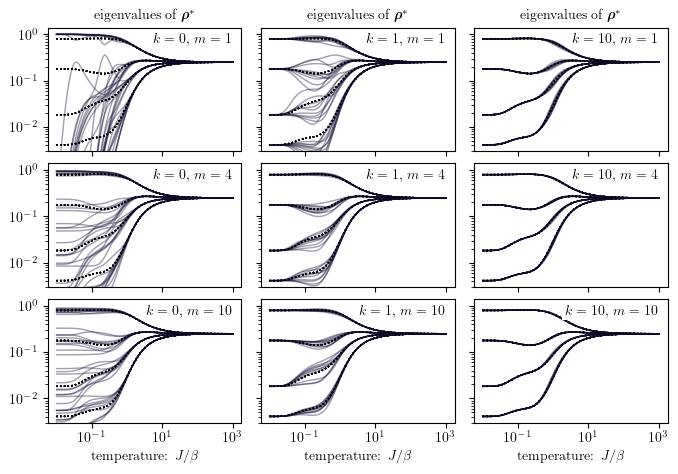

In [12]:
fig,axs = plt.subplots(len(ms),len(ks),figsize=(8,5),sharex=True,sharey=True)
plt.subplots_adjust(bottom=.09,wspace=.1,hspace=.1)


c = plt.cm.magma(.1)
for ki,k in enumerate(ks):
    for mi,m in enumerate(ms):
        
        axs[mi,ki].text(.95,.95,rf'$k={k}$, $m={m}$',ha='right', va='top', transform=axs[mi,ki].transAxes,bbox=dict(facecolor='white',edgecolor='none',pad=2))

        for i in range(n_trials):
            ρ_EVs = ρ_EVs_all[i]

            axs[mi,ki].plot(1/βs,ρ_EVs_true,color='k',ls=':',lw=1)
    
            if k==0 and m==0: 
                continue
                
            axs[mi,ki].plot(1/βs,ρ_EVs[k,m],color=c,alpha=.4,lw=1)
        
    
    axs[-1,ki].set_xlabel(rf'temperature: $J/\beta$')
        
    axs[0,ki].set_title(rf'eigenvalues of $\bm\rho^*$',fontsize=10)

plt.yscale('log')
plt.ylim(3e-3,1.4)
plt.xscale('log')

plt.savefig('imgs/solvable_comparison.pdf')

In [13]:
ρ_EVs_LOO_est = {k:np.zeros((m,n_βs,d_a)) for k in ks}
ρ_EVs_LOO_var = {k:np.zeros((n_βs,d_a)) for k in ks}

i = n_trials # use data not used in previous plot
m = 10 # set m value
out = out_all[i]

for ki,k in enumerate(ks):
    for l,β in enumerate(βs):
        
        # define function
        f = lambda x: np.exp(-β*(x-E0))
  
        # get partial traces by leaving out one term in sum (list of partial traces)
        Tr = form_matfunc_LOO_ptrace(f,*out[k,m])

        for j in range(m):
            
            # for each in list, get eigenvalues
            try:
                ρ_EVs_LOO_est[k][j,l] = np.linalg.eigvalsh(Tr[j])/np.trace(Tr[j])
            except: 
                pass

        # compute variance of LOO eigenvalues
        ρ_EVs_LOO_var[k][l] = m*np.var(ρ_EVs_LOO_est[k][:,l],axis=0)

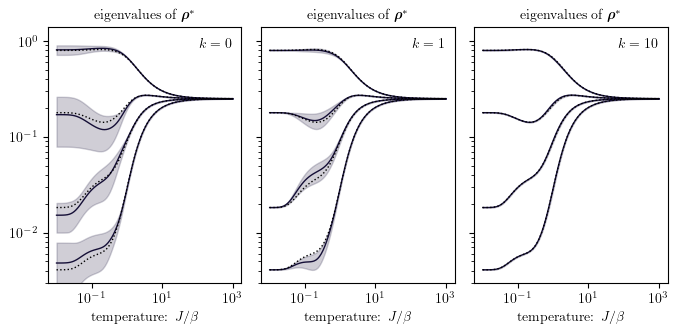

In [14]:
fig,axs = plt.subplots(1,3,figsize=(8,3.5),sharex=True,sharey=True)
plt.subplots_adjust(bottom=.15,wspace=.1)

for ki,k in enumerate(ks):

    c = plt.cm.magma(.1)
    for p in range(d_a):
        axs[ki].fill_between(1/βs,ρ_EVs[k,m][:,p]+ρ_EVs_LOO_var[k][:,p]**.5,\
                                  ρ_EVs[k,m][:,p]-ρ_EVs_LOO_var[k][:,p]**.5,color=c,alpha=.2)

        axs[ki].plot(1/βs,ρ_EVs[k,m][:,p],color=c,alpha=1,lw=1)

    axs[ki].plot(1/βs,ρ_EVs_true,color='k',ls=':',lw=1)

    axs[ki].text(.95,.96,rf'$k={k}$',ha='right', va='top', transform=axs[ki].transAxes,bbox=dict(facecolor='white',edgecolor='none',pad=2))

    axs[ki].set_xlabel(rf'temperature: $J/\beta$')
    
    
    axs[ki].set_title(rf'eigenvalues of $\bm\rho^*$',fontsize=10)

plt.yscale('log')
plt.ylim(3e-3,1.4)
plt.xscale('log')

plt.savefig('imgs/solvable_comparison_est_errs.pdf')